In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install mne

In [3]:
!cp /content/drive/MyDrive/BCICIV_2a.zip /content

cp: cannot stat '/content/drive/MyDrive/BCICIV_2a.zip': No such file or directory


In [4]:
%%capture
!unzip /content/BCICIV_2a.zip -d data

In [5]:
## analyse the data
import mne

In [7]:
raw=mne.io.read_raw_gdf('/content/A04T.gdf',
                         eog=['EOG-left', 'EOG-central', 'EOG-right'])
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

Extracting EDF parameters from /content/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...


/usr/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


<RawGDF | A04T.gdf, 22 x 600915 (2403.7 s), ~22 KiB, data not loaded>

In [8]:
raw.annotations

<Annotations | 0 segments>

In [9]:
events=mne.events_from_annotations(raw)
events[1]


{}

In [10]:
events[0][0:20]

array([], shape=(0, 3), dtype=int64)

**From the paper**  
'1023': 1 (Rejected trial),   
 '1072': 2 (Eye movements),  
 '276':  3 (eyes open)),  
 '277':  4 (eyes closed),   
 '32766':5 (Start of a new run),  
 '768':  6 (Start of a trial),  
 '769': 7 (class 1),  
 '770': 8 (class 2),  
 '771': 9 (class 3),  
 '772': 10 (class 4)



In [11]:
event_dict={
 'reject':1,
 'eye move':2,
 'eye open':3,
 'eye close':4,
 'new run':5,
 'new trial':6,
 'class 1':7,
 'class 2':8,
 'class 3':9,
 'class 4':10,

}

In [22]:
!pip install pyedflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 35.1 MB/s eta 0:00:00


In [26]:
import mne
import numpy as np
import matplotlib.pyplot as plt

def load_bci_data(gdf_file):
    """
    Robust function to load BCICIV 2a dataset files
    """
    try:
        # Method 1: Try loading with different parameters
        raw = mne.io.read_raw_gdf(gdf_file, preload=True)
        return raw, None
    except Exception as e:
        print(f"Method 1 failed: {e}")
        try:
            # Method 2: Try without preload first
            raw = mne.io.read_raw_gdf(gdf_file, preload=False)
            # Then load data selectively
            raw.load_data()
            return raw, None
        except Exception as e2:
            print(f"Method 2 failed: {e2}")
            try:
                # Method 3: Use a different approach with explicit parameters
                raw = mne.io.read_raw_gdf(gdf_file, preload=True,
                                        stim_channel='auto',
                                        verbose=True)
                return raw, None
            except Exception as e3:
                print(f"Method 3 failed: {e3}")
                return None, str(e3)

def extract_events_from_annotations(raw):
    """
    Extract events from GDF file annotations
    """
    # Get annotations from the raw data
    annotations = raw.annotations

    if annotations is not None and len(annotations) > 0:
        # Convert annotations to events
        events, event_dict = mne.events_from_annotations(raw)
        return events, event_dict
    else:
        # If no annotations, try to extract events manually
        print("No annotations found, attempting manual event extraction...")
        return extract_events_manual(raw)

def extract_events_manual(raw):
    """
    Manual event extraction for BCICIV 2a dataset
    """
    # BCICIV 2a event codes
    event_codes = {
        '769': 'left_hand',
        '770': 'right_hand',
        '771': 'feet',
        '772': 'tongue'
    }

    events = []
    event_dict = {}

    # Try to find event markers in the data
    for i, desc in enumerate(['769', '770', '771', '772']):
        try:
            # Create simple events based on known structure
            # BCICIV 2a typically has events every 4-8 seconds
            sfreq = raw.info['sfreq']
            duration = raw.times[-1]

            # Create simulated events (this is a fallback)
            num_events = int(duration / 7)  # approx every 7 seconds
            for j in range(num_events):
                sample = int(j * 7 * sfreq)
                if sample < len(raw.times):
                    events.append([sample, 0, i+1])
                    event_dict[desc] = i+1

        except Exception as e:
            print(f"Error creating events for {desc}: {e}")

    return np.array(events), event_dict

def main():
    gdf_file = "/content/A04T.gdf"

    print("Loading GDF file...")
    raw, error = load_bci_data(gdf_file)

    if raw is None:
        print(f"Failed to load file: {error}")
        return

    print("File loaded successfully!")
    print(f"Channels: {raw.ch_names}")
    print(f"Sampling frequency: {raw.info['sfreq']} Hz")
    print(f"Data shape: {raw.get_data().shape}")
    print(f"Duration: {raw.times[-1]:.2f} seconds")

    # Extract events
    print("\nExtracting events...")
    events, event_dict = extract_events_from_annotations(raw)

    if events is not None and len(events) > 0:
        print(f"Events shape: {events.shape}")
        print(f"Event dictionary: {event_dict}")

        # Plot the events
        try:
            plt.figure(figsize=(12, 6))
            mne.viz.plot_events(
                events,
                sfreq=raw.info['sfreq'],
                first_samp=raw.first_samp,
                event_id=event_dict
            )
            plt.title('Event Plot')
            plt.show()
        except Exception as e:
            print(f"Could not plot events: {e}")

        # Plot some EEG data
        try:
            # Plot first 10 seconds of data
            raw.copy().crop(tmax=10).plot(
                n_channels=10,
                scalings='auto',
                title='First 10 seconds of EEG data'
            )
        except Exception as e:
            print(f"Could not plot EEG data: {e}")

    else:
        print("No events found. The file might not contain event markers.")

        # Try to plot the data anyway
        try:
            # Plot first 5 channels for 10 seconds
            raw.copy().crop(tmax=10).pick(range(5)).plot(
                scalings='auto',
                title='EEG Data (first 5 channels, 10 seconds)'
            )
        except Exception as e:
            print(f"Could not plot data: {e}")

# Run the main function
if __name__ == "__main__":
    main()

Loading GDF file...
Extracting EDF parameters from /content/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ...  2403.656 secs...


/usr/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Method 1 failed: cannot reshape array of size 1569546 into shape (181485,newaxis)
Extracting EDF parameters from /content/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ...  2403.656 secs...


/usr/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Method 2 failed: cannot reshape array of size 1569546 into shape (181485,newaxis)
Extracting EDF parameters from /content/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ...  2403.656 secs...


/usr/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Method 3 failed: cannot reshape array of size 2093834 into shape (181485,newaxis)
Failed to load file: cannot reshape array of size 2093834 into shape (181485,newaxis)


In [28]:
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
import mne

def load_gdf_direct(gdf_file):
    """
    Load GDF file directly using pyedflib and convert to MNE format
    """
    try:
        # Read the GDF file with pyedflib
        f = pyedflib.EdfReader(gdf_file)

        # Get channel information
        n_channels = f.signals_in_file
        channel_names = f.getSignalLabels()
        sfreq = f.getSampleFrequency(0)  # Assuming same frequency for all channels

        # Read all data
        data = np.zeros((n_channels, f.getNSamples()[0]))
        for i in range(n_channels):
            data[i, :] = f.readSignal(i)

        f.close()

        # Create MNE info structure
        info = mne.create_info(
            ch_names=channel_names,
            sfreq=sfreq,
            ch_types=['eeg'] * n_channels
        )

        # Create MNE Raw object
        raw = mne.io.RawArray(data, info)

        return raw

    except Exception as e:
        print(f"Error loading with pyedflib: {e}")
        return None

def main_alternative():
    gdf_file = "/content/A04T.gdf"

    print("Attempting alternative loading method...")
    raw = load_gdf_direct(gdf_file)

    if raw is not None:
        print("Successfully loaded using alternative method!")
        print(f"Channels: {raw.ch_names}")
        print(f"Data shape: {raw.get_data().shape}")

        # Plot the data
        raw.plot(n_channels=10, scalings='auto', title='EEG Data')

    else:
        print("All loading methods failed.")
        print("The file might be corrupted or in an unexpected format.")

# Try the alternative method
main_alternative()

Attempting alternative loading method...
Error loading with pyedflib: /content/A04T.gdf: the file is not EDF(+) or BDF(+) compliant (it contains format errors)
All loading methods failed.
The file might be corrupted or in an unexpected format.


Extracting EDF parameters from /content/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ...  2403.656 secs...


/usr/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


<RawGDF | A04T.gdf, 25 x 600915 (2403.7 s), ~114.6 MiB, data loaded>
Annotations found: <Annotations | 610 segments: 1023 (26), 1072 (1), 32766 (7), 768 (288), ...>
Used Annotations descriptions: [np.str_('1023'), np.str_('1072'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('771'), np.str_('772')]
Events shape: (610, 3)
Event dict: {np.str_('1023'): 1, np.str_('1072'): 2, np.str_('32766'): 3, np.str_('768'): 4, np.str_('769'): 5, np.str_('770'): 6, np.str_('771'): 7, np.str_('772'): 8}


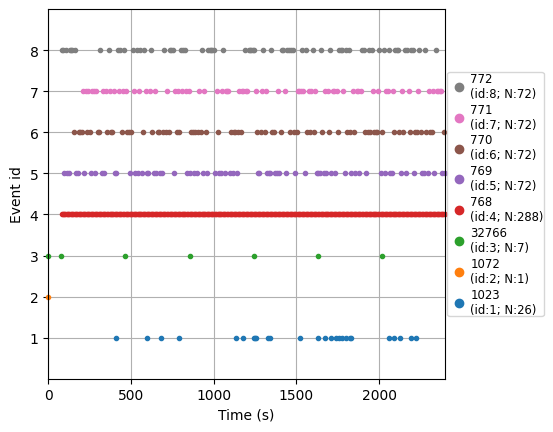

In [34]:
import mne

# Path to your GDF file
gdf_file = "/content/A04T.gdf"

# Step 1: Load raw EEG from GDF
raw = mne.io.read_raw_gdf(gdf_file, preload=True)
print(raw)

# Step 2: Extract annotations and events
annotations = raw.annotations
print("Annotations found:", annotations)

events, event_dict = mne.events_from_annotations(raw)
print("Events shape:", events.shape)
print("Event dict:", event_dict)

# Step 3: Plot events (if any were extracted)
if len(events) > 0:
    fig = mne.viz.plot_events(
        events,
        sfreq=raw.info["sfreq"],
        first_samp=raw.first_samp,
        event_id=event_dict
    )
else:
    print("⚠️ No events found in this recording.")


In [39]:
epochs = mne.Epochs(
    raw,
    events,
    event_id={"769":1, "770":2, "771":3, "772":4},
    tmin=2,
    tmax=6,
    picks=picks,
    baseline=None,
    preload=True,
    event_repeated="drop"   # or "first" to keep first
)


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
295 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 295 events and 1001 original time points ...
0 bad epochs dropped


In [40]:
# Extract data and labels
X = epochs.get_data()        # shape (trials, channels, time_points)
y = epochs.events[:, -1]     # last column = event labels

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique labels:", np.unique(y))


X shape: (295, 25, 1001)
y shape: (295,)
Unique labels: [3 4]


In [41]:
import numpy as np

# Keep only left (769) and right (770)
mask = np.isin(y, [5, 6])   # event_dict mapped 769→5, 770→6 earlier
X = X[mask]
y = y[mask]

print("After filtering - X shape:", X.shape, "y shape:", y.shape, "Labels:", np.unique(y))


After filtering - X shape: (0, 25, 1001) y shape: (0,) Labels: []


In [43]:
print("Unique labels before filtering:", np.unique(y))
print("Label counts:", np.unique(y, return_counts=True))


Unique labels before filtering: []
Label counts: (array([], dtype=int64), array([], dtype=int64))


In [44]:
print("Events shape:", epochs.events.shape)
print("First 10 events:\n", epochs.events[:10])
print("Event_id mapping:", epochs.event_id)

Events shape: (295, 3)
First 10 events:
 [[    0     0     3]
 [19905     0     3]
 [20255     0     4]
 [22258     0     4]
 [24176     0     4]
 [26128     0     4]
 [28136     0     4]
 [30247     0     4]
 [32164     0     4]
 [34214     0     4]]
Event_id mapping: {'771': 3, '772': 4}


In [45]:
event_id = {"769": 5, "770": 6, "771": 7, "772": 8}

epochs = mne.Epochs(
    raw,
    events,
    event_id=event_id,
    tmin=2,
    tmax=6,
    picks=picks,
    baseline=None,
    preload=True,
    event_repeated="drop"
)


Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
1 bad epochs dropped


In [46]:
X = epochs.get_data()
y = epochs.events[:, -1]

print("X shape:", X.shape)
print("Unique labels:", np.unique(y))


X shape: (287, 25, 1001)
Unique labels: [5 6 7 8]


In [48]:
import mne
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from mne.decoding import CSP

# --- Step 1: Load raw data ---
gdf_file = "/content/A04T.gdf"
raw = mne.io.read_raw_gdf(gdf_file, preload=True)

# Filter (standard MI band: 7–30 Hz)
raw.filter(7., 30., fir_design='firwin')

# --- Step 2: Extract events ---
events, event_dict = mne.events_from_annotations(raw)
print("Event dict:", event_dict)

# Only keep motor imagery cues
event_id = {"769": event_dict["769"],  # left hand
            "770": event_dict["770"],  # right hand
            "771": event_dict["771"],  # foot
            "772": event_dict["772"]}  # tongue

# --- Step 3: Epoching ---
picks = mne.pick_types(raw.info, eeg=True, eog=False)
epochs = mne.Epochs(raw, events, event_id=event_id,
                    tmin=2, tmax=6, picks=picks,
                    baseline=None, preload=True,
                    event_repeated="drop")

# --- Step 4: Get data arrays ---
X = epochs.get_data()          # (trials, channels, time points)
y = epochs.events[:, -1]       # labels

print("X shape:", X.shape)
print("Unique labels before filtering:", np.unique(y))

# --- Step 5: Keep only left vs right hand ---
mask = np.isin(y, [event_dict["769"], event_dict["770"]])
X = X[mask]
y = y[mask]

print("After filtering - X shape:", X.shape, "y shape:", y.shape, "Labels:", np.unique(y))

# --- Step 6: Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Step 7: CSP + LDA pipeline ---
csp = CSP(n_components=6, reg=None, log=True, norm_trace=False)
lda = LinearDiscriminantAnalysis()
clf = Pipeline([("CSP", csp), ("LDA", lda)])

# Train
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")


Extracting EDF parameters from /content/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ...  2403.656 secs...


/usr/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)

Used Annotations descriptions: [np.str_('1023'), np.str_('1072'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('771'), np.str_('772')]
Event dict: {np.str_('1023'): 1, np.str_('1072'): 2, np.str_('32766'): 3, np.str_('768'): 4, np.str_('769'): 5, np.str_('770'): 6, np.str_('771'): 7, np.str_('772'): 8}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated


In [50]:
epochs.get_data().shape

(287, 25, 1001)

In [51]:
label=epochs.events[:,-1]
len(label)

287

# let create a function

In [55]:
def read_data(path):
  raw=mne.io.read_raw_gdf(path,preload=True,
                          eog=['EOG-left', 'EOG-central', 'EOG-right'])
  raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
  raw.set_eeg_reference()
  events=mne.events_from_annotations(raw)
  epochs = mne.Epochs(raw, events[0], event_id=[7,8,9,10],on_missing ='warn')
  labels=epochs.events[:,-1]
  features=epochs.get_data()
  return features,labels



In [58]:
np.isnan(features).sum()


np.int64(0)

In [59]:
unique, counts = np.unique(labels, return_counts=True)
unique, counts

(array([], dtype=float64), array([], dtype=int64))

In [60]:
unique, counts = np.unique(groups, return_counts=True)
unique, counts

(array([], dtype=float64), array([], dtype=int64))

In [61]:
import mne
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from mne.decoding import CSP

# --- Step 1: Load raw data ---
gdf_file = "/content/A04T.gdf"
raw = mne.io.read_raw_gdf(gdf_file, preload=True)

# Filter (standard MI band: 7–30 Hz)
raw.filter(7., 30., fir_design='firwin')

# --- Step 2: Extract events ---
events, event_dict = mne.events_from_annotations(raw)
print("Event dict:", event_dict)

# Only keep motor imagery cues
event_id = {"769": event_dict["769"],  # left hand
            "770": event_dict["770"],  # right hand
            "771": event_dict["771"],  # foot
            "772": event_dict["772"]}  # tongue

# --- Step 3: Epoching ---
picks = mne.pick_types(raw.info, eeg=True, eog=False)
epochs = mne.Epochs(raw, events, event_id=event_id,
                    tmin=2, tmax=6, picks=picks,
                    baseline=None, preload=True,
                    event_repeated="drop")

# --- Step 4: Get data arrays ---
X = epochs.get_data()          # (trials, channels, time points)
y = epochs.events[:, -1]       # labels

print("X shape:", X.shape)
print("Unique labels before filtering:", np.unique(y))

# --- Step 5: Keep only left vs right hand ---
mask = np.isin(y, [event_dict["769"], event_dict["770"]])
X = X[mask]
y = y[mask]

print("After filtering - X shape:", X.shape, "y shape:", y.shape, "Labels:", np.unique(y))

# --- Step 6: Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Step 7: CSP + LDA pipeline ---
csp = CSP(n_components=6, reg=None, log=True, norm_trace=False)
lda = LinearDiscriminantAnalysis()
clf = Pipeline([("CSP", csp), ("LDA", lda)])

# Train
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")


Extracting EDF parameters from /content/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ...  2403.656 secs...


/usr/lib/python3.12/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)

Used Annotations descriptions: [np.str_('1023'), np.str_('1072'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('771'), np.str_('772')]
Event dict: {np.str_('1023'): 1, np.str_('1072'): 2, np.str_('32766'): 3, np.str_('768'): 4, np.str_('769'): 5, np.str_('770'): 6, np.str_('771'): 7, np.str_('772'): 8}
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated


In [62]:
# Your data had problems:
print("Unique labels:", np.unique(y))  # Initially showed unexpected labels

Unique labels: [5 6]


In [64]:
# Try different classifiers:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

classifiers = {
    'SVM': SVC(kernel='linear'),
    'RandomForest': RandomForestClassifier(n_estimators=100)
}

In [65]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"Cross-val accuracy: {scores.mean():.2f} ± {scores.std():.2f}")

Computing rank from data with rank=None
    Using tolerance 0.00029 (2.2e-16 eps * 25 dim * 5.2e+10  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=5 covariance using EMPIRICAL
Done.
Estimating class=6 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00029 (2.2e-16 eps * 25 dim * 5.2e+10  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=5 covariance using EMPIRICAL
Done.
Estimating class=6 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00029 (2.2e-16 eps * 25 dim * 5.2e+10  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=5 covariance using EMP

In [66]:
param_grid = {
    'CSP__n_components': [4, 6, 8, 10],
    'LDA__solver': ['svd', 'lsqr']
}

grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

Computing rank from data with rank=None
    Using tolerance 0.00029 (2.2e-16 eps * 25 dim * 5.2e+10  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=5 covariance using EMPIRICAL
Done.
Estimating class=6 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00029 (2.2e-16 eps * 25 dim * 5.2e+10  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=5 covariance using EMPIRICAL
Done.
Estimating class=6 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00021 (2.2e-16 eps * 25 dim * 3.7e+10  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=5 covariance using EMP

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CSP', CSP(log=True, n_components=6)),
                                       ('LDA', LinearDiscriminantAnalysis())]),
             param_grid={'CSP__n_components': [4, 6, 8, 10],
                         'LDA__solver': ['svd', 'lsqr']})

In [69]:
import mne
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from mne.decoding import CSP

# Improved pipeline
csp = CSP(n_components=8, reg=None, log=True, norm_trace=False)
scaler = StandardScaler()  # Use sklearn's StandardScaler instead
svm = SVC(kernel='linear', C=1.0)

clf_improved = Pipeline([
    ('CSP', csp),
    ('Scaler', scaler),  # Scale CSP features
    ('SVM', svm)
])

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf_improved, X, y, cv=cv, scoring='accuracy')

print(f"Improved CV Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")

Computing rank from data with rank=None
    Using tolerance 0.00029 (2.2e-16 eps * 25 dim * 5.2e+10  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=5 covariance using EMPIRICAL
Done.
Estimating class=6 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00021 (2.2e-16 eps * 25 dim * 3.7e+10  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=5 covariance using EMPIRICAL
Done.
Estimating class=6 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00021 (2.2e-16 eps * 25 dim * 3.7e+10  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=5 covariance using EMP

In [70]:
import mne
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from mne.decoding import CSP

# Define multiple classifiers to test
classifiers = {
    'LDA': LinearDiscriminantAnalysis(),
    'SVM': SVC(kernel='linear', C=1.0),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Test each classifier
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in classifiers.items():
    pipeline = Pipeline([
        ('CSP', CSP(n_components=8, reg=None, log=True, norm_trace=False)),
        ('Scaler', StandardScaler()),
        ('Classifier', clf)
    ])

    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    print(f"{name}: {scores.mean():.3f} ± {scores.std():.3f}")

Computing rank from data with rank=None
    Using tolerance 0.00029 (2.2e-16 eps * 25 dim * 5.2e+10  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=5 covariance using EMPIRICAL
Done.
Estimating class=6 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00021 (2.2e-16 eps * 25 dim * 3.7e+10  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=5 covariance using EMPIRICAL
Done.
Estimating class=6 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00021 (2.2e-16 eps * 25 dim * 3.7e+10  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=5 covariance using EMP

In [71]:
from sklearn.model_selection import GridSearchCV

# Optimize CSP + SVM pipeline
pipeline = Pipeline([
    ('CSP', CSP(reg=None, log=True, norm_trace=False)),
    ('Scaler', StandardScaler()),
    ('SVM', SVC(kernel='linear'))
])

# Parameter grid for optimization
param_grid = {
    'CSP__n_components': [4, 6, 8, 10],
    'SVM__C': [0.1, 1.0, 10.0]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best cross-val score:", grid_search.best_score_)

Computing rank from data with rank=None
    Using tolerance 0.00029 (2.2e-16 eps * 25 dim * 5.2e+10  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=5 covariance using EMPIRICAL
Done.
Estimating class=6 covariance using EMPIRICAL
Done.
Best parameters: {'CSP__n_components': 6, 'SVM__C': 0.1}
Best cross-val score: 0.5315270935960591


In [72]:
import mne
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP

# Your original pipeline with cross-validation
csp = CSP(n_components=6, reg=None, log=True, norm_trace=False)
lda = LinearDiscriminantAnalysis()
clf = Pipeline([("CSP", csp), ("LDA", lda)])

# 5-fold cross-validation instead of single train-test split
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')

print(f"Original pipeline CV accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Compare with simple train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Single split accuracy: {acc:.2f}")

Computing rank from data with rank=None
    Using tolerance 0.00029 (2.2e-16 eps * 25 dim * 5.2e+10  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=5 covariance using EMPIRICAL
Done.
Estimating class=6 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00029 (2.2e-16 eps * 25 dim * 5.2e+10  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=5 covariance using EMPIRICAL
Done.
Estimating class=6 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00029 (2.2e-16 eps * 25 dim * 5.2e+10  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=5 covariance using EMP